In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pylab import cm as cmaps
from pylab import rcParams
import healpy as hp
from tqdm import *
from astropy import units as u
from scipy.ndimage.filters import gaussian_filter

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from plot_params import params
from simulation.astrometry_sim import QuasarSim
from theory.units import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
pylab.rcParams.update(params)
plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/LensPower/Draft/plots/"
# plots_dir = "/Users/smsharma/Desktop/LensPower_Offline/plots/"

data_dir = "/Users/smsharma/QuasarSims/"

/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


## Figure 1: induced velocity and acceleration maps

Simulate a subhalo sample and compute lens-induced velocities and accelerations.

In [3]:
max_sep = 20
nside = 128
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True, 
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=True, 
                do_alpha=True,
                sh_profile='Gaussian')

sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1e10 * M_s, N_calib=150, alpha=-1.9)
sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
sim.set_subhalo_properties(sim.c200_SCP, distdep=False)

Simulating 1248 subhalos between 7.0 and 10.0


In [78]:
sim.analysis_pipeline()

np.save("../../data/mu_qsrs", sim.mu_qsrs)
np.save("../../data/alpha_qsrs", sim.alpha_qsrs)

In [4]:
sim.mu_qsrs = np.load("../data/mu_qsrs.npy")
sim.alpha_qsrs = np.load("../data/alpha_qsrs.npy")

<Figure size 990x673.2 with 0 Axes>

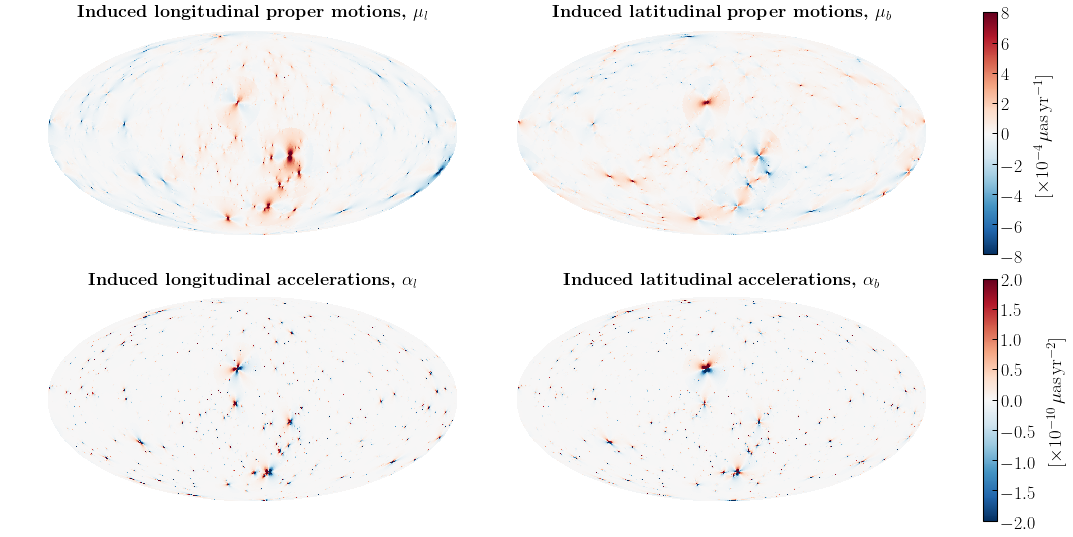

In [131]:
max_mu = 8e-4 / 1e-4
max_alpha = 2e-10 / 1e-10

cmap = cmaps.RdBu_r
cmap.set_under('w')

fig = plt.figure(figsize=(1.1 * 12.5, 1.1 * 8.5)) 
# gs = gridspec.GridSpec(2, 3, width_ratios=[5, 5, 1], hspace=0.1, wspace=0.1) 

# ax1 = plt.subplot(gs[1])
# fig = plt.gcf()
# fig.set_size_inches(1.1 * 12.5, 1.1 * 8.5)

fig, axes = plt.subplots(2, 3, figsize=(1.1 * 15.5, 1.1 * 8.5), gridspec_kw={'width_ratios': [2.2, 2.2, .075], 'hspace':0.1})

plt.axes(axes[0,0])
hp.mollview(1e6 * sim.mu_qsrs[:,0] / 1e-4,max=max_mu, min=-max_mu, title=r"\bf{Induced longitudinal proper motions}, $\mu_l$", unit='$\mu$as\,yr$^{-1}$', cmap=cmap, sub=(2,3,1), cbar=None,hold=True)
plt.axes(axes[0,1])
hp.mollview(1e6 * sim.mu_qsrs[:,1] / 1e-4,max=max_mu, min=-max_mu, title=r"\bf{Induced latitudinal proper motions}, $\mu_b$", unit='$\mu$as\,yr$^{-1}$', cmap=cmap, sub=(2,3,2), cbar=None,hold=True)

fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
fig.colorbar(image, axes[0,2], label=r'$[\times 10^{-4}\,\mu$as\,yr$^{-1}]$')

plt.axes(axes[1,0])
hp.mollview(1e6 * sim.alpha_qsrs[:,0] / 1e-10,max=max_alpha, min=-max_alpha, title=r"\bf{Induced longitudinal accelerations}, $\alpha_l$", unit='$\mu$as\,yr$^{-2}$', cmap=cmap, sub=(2,3,4), cbar=None,hold=True)
plt.axes(axes[1,1])
hp.mollview(1e6 * sim.alpha_qsrs[:,1] / 1e-10,max=max_alpha, min=-max_alpha, title=r"\bf{Induced latitudinal accelerations}, $\alpha_b$", unit='$\mu$as\,yr$^{-2}$', cmap=cmap, sub=(2,3,5), cbar=None,hold=True)

fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]
cbar2 = fig.colorbar(image, axes[1,2], label=r'$[\times 10^{-10}\,\mu$as\,yr$^{-2}]$', shrink=1e10)

plt.tight_layout()
plt.savefig(plots_dir + "/maps_mu_alpha.pdf", bbox_inches='tight')

In [9]:
from matplotlib import gridspec

# generate some data
x = np.arange(0, 10, 0.2)
y = np.sin(x)

# plot it
fig = plt.figure(figsize=(18, 6)) 
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 2.5, 1], hspace=0.1) 


<Figure size 1296x432 with 0 Axes>

## Figure 10: azimuthal asymmetry

Analyze cluster runs to get azimuthal asymmetry over $m$-modes. Obtained by running `simulation/cluster/submit_uniform.py`.

### CDM-like case

In [3]:
nsim = 500
nside = 128
lmax = 3 * nside - 1
lmin_plot = 10
lmax_plot = 200

In [4]:
fB_ary = np.zeros((lmax, lmax))
for i in tqdm_notebook(range(nsim)):
    fB = np.load(data_dir + "/gaussian_nside128_sep20_mc" + str(i) + ".npz")['fB']
    fB_ary += np.abs(fB*1e6)**2
fB_ary /= nsim

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [5]:
fB_ary_compressed = (fB_ary)[lmin_plot:lmax_plot,lmin_plot:lmax_plot]

In [6]:
av_ary = np.zeros_like(fB_ary_compressed)
for l in range(len(av_ary)):
    thing = np.where(fB_ary_compressed[l, :]!=0,fB_ary_compressed[l, :],np.nan)
    av_ary[l, :l] = ((thing - np.nanmean(thing)) / np.nanmean(thing))[:l]
# plt.plot((thing - np.nanmean(thing)) / thing)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [7]:
fB_alpha_ary = np.zeros((lmax, lmax))
for i in tqdm_notebook(range(nsim)):
    fB_alpha = np.load(data_dir + "/gaussian_nside128_sep20_mc" + str(i) + ".npz")['fB_alpha']
    fB_alpha_ary += np.abs(fB_alpha*1e6)**2
fB_alpha_ary /= nsim

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [8]:
fB_alpha_ary_compressed = (fB_alpha_ary)[lmin_plot:lmax_plot,lmin_plot:lmax_plot]

In [9]:
av_alpha_ary = np.zeros_like(fB_alpha_ary_compressed)
for l in range(len(av_alpha_ary)):
    thing = np.where(fB_alpha_ary_compressed[l, :]!=0,fB_alpha_ary_compressed[l, :],np.nan)
    av_alpha_ary[l, :l] = ((thing - np.nanmean(thing)) / np.nanmean(thing))[:l]
# plt.plot((thing - np.nanmean(thing)) / thing)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


### Compact objects case

In [10]:
nsim = range(500)

fB_compact_ary = np.zeros((lmax, lmax))
for i in tqdm_notebook(nsim):
#     fB = np.load(data_dir + "/gaussian_uniform_f0p1_M1e8_R1e2_nside128_sep20_mc" + str(i) + ".npz")['fB']
    fB = np.load(data_dir + "/gaussian_uniform_galNFW_f0p2_M1e8_R1e2_nside128_sep20_mc" + str(i) + ".npz")['fB']
    fB_compact_ary += np.abs(5 * fB*1e6)**2
fB_compact_ary /= len(nsim)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [11]:
fB_compact_ary_compressed = (fB_compact_ary)[lmin_plot:lmax_plot,lmin_plot:lmax_plot]

In [12]:
av_compact_ary = np.zeros_like(fB_compact_ary_compressed)
for l in range(len(av_ary)):
    thing = np.where(fB_compact_ary_compressed[l, :]!=0,fB_compact_ary_compressed[l, :],np.nan)
    av_compact_ary[l, :l] = ((thing - np.nanmean(thing)) / np.nanmean(thing))[:l]
# plt.plot((thing - np.nanmean(thing)) / thing)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [13]:
fB_alpha_compact_ary = np.zeros((lmax, lmax))
for i in tqdm_notebook(nsim):
#     fB = np.load(data_dir + "/gaussian_uniform_f0p1_M1e8_R1e2_nside128_sep20_mc" + str(i) + ".npz")['fB']
    fB = np.load(data_dir + "/gaussian_uniform_galNFW_f0p2_M1e8_R1e2_nside128_sep20_mc" + str(i) + ".npz")['fB_alpha']
    fB_alpha_compact_ary += np.abs(5 * fB*1e6)**2
fB_alpha_compact_ary /= len(nsim)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [14]:
fB_alpha_compact_ary_compressed = (fB_alpha_compact_ary)[lmin_plot:lmax_plot,lmin_plot:lmax_plot]

In [15]:
av_alpha_compact_ary = np.zeros_like(fB_alpha_compact_ary_compressed)
for l in range(len(av_alpha_compact_ary)):
    thing = np.where(fB_alpha_compact_ary_compressed[l, :]!=0,fB_alpha_compact_ary_compressed[l, :],np.nan)
    av_alpha_compact_ary[l, :l] = ((thing - np.nanmean(thing)) / np.nanmean(thing))[:l]
# plt.plot((thing - np.nanmean(thing)) / thing)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


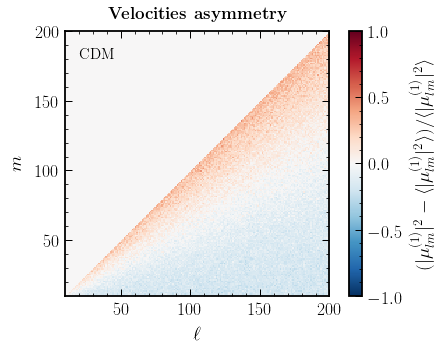

In [16]:
plt.figure(figsize=(8 / 1.2, 6 / 1.2))

plt.imshow(np.transpose(gaussian_filter(av_ary, 0)), 
           origin='lower', vmin=-1., vmax=1.,
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot],
           cmap='RdBu_r'
          )

cbar = plt.colorbar(label=r"$(|\mu_{lm}^{(1)}|^2 - \langle|\mu_{lm}^{(1)}|^2\rangle) / \langle|\mu_{lm}^{(1)}|^2\rangle$")

plt.ylabel("$m$")
plt.xlabel("$\ell$")

plt.title('\\textbf{Velocities asymmetry}', fontsize=17, y=1.02)
plt.text(20, 180, "CDM", fontsize=15)
plt.tight_layout()
plt.savefig(plots_dir + "m_asymm_1.pdf")

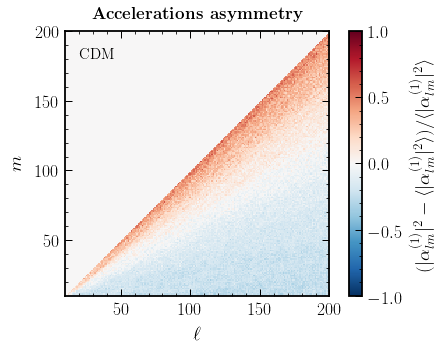

In [17]:
plt.figure(figsize=(8 / 1.2, 6 / 1.2))

plt.imshow(np.transpose(gaussian_filter(av_alpha_ary, 0)), 
           origin='lower', vmin=-1., vmax=1.,
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot],
#            cmap=palettable.cmocean.sequential.Ice_20_r.get_mpl_colormap(),
           cmap='RdBu_r'
          )

cbar = plt.colorbar(label=r"$(|\alpha_{lm}^{(1)}|^2 - \langle|\alpha_{lm}^{(1)}|^2\rangle) / \langle|\alpha_{lm}^{(1)}|^2\rangle$")

plt.ylabel("$m$")
plt.xlabel("$\ell$")

plt.title('\\textbf{Accelerations asymmetry}', fontsize=17, y=1.02)

plt.text(20, 180, "CDM", fontsize=15)

plt.tight_layout()
plt.savefig(plots_dir + "m_asymm_alpha_1.pdf")

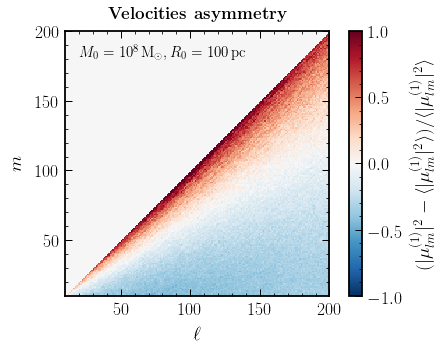

In [18]:
plt.figure(figsize=(8 / 1.2, 6 / 1.2))

plt.imshow(np.transpose(gaussian_filter(av_compact_ary, 0)), 
           origin='lower', vmin=-1., vmax=1.,
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot],
           cmap='RdBu_r'
          )

cbar = plt.colorbar(label=r"$(|\mu_{lm}^{(1)}|^2 - \langle|\mu_{lm}^{(1)}|^2\rangle) / \langle|\mu_{lm}^{(1)}|^2\rangle$")

plt.ylabel("$m$")
plt.xlabel("$\ell$")

plt.title('\\textbf{Velocities asymmetry}', fontsize=17, y=1.02)

plt.text(20, 180, "$M_0 = 10^8\,\mathrm{M}_\odot, R_0 = 100\,\mathrm{pc}$", fontsize=15)

plt.tight_layout()
plt.savefig(plots_dir + "m_compact_asymm_1.pdf")

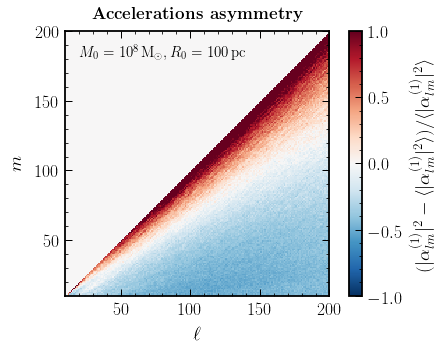

In [19]:
plt.figure(figsize=(8 / 1.2, 6 / 1.2))

plt.imshow(np.transpose(gaussian_filter(av_alpha_compact_ary, 0)), 
           origin='lower', vmin=-1., vmax=1.,
            extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot],
#            cmap=palettable.cmocean.sequential.Ice_20_r.get_mpl_colormap(),
           cmap='RdBu_r'
          )

cbar = plt.colorbar(label=r"$(|\alpha_{lm}^{(1)}|^2 - \langle|\alpha_{lm}^{(1)}|^2\rangle) / \langle|\alpha_{lm}^{(1)}|^2\rangle$")

plt.ylabel("$m$")
plt.xlabel("$\ell$")

plt.title('\\textbf{Accelerations asymmetry}', fontsize=17, y=1.02)

plt.text(20, 180, "$M_0 = 10^8\,\mathrm{M}_\odot, R_0 = 100\,\mathrm{pc}$", fontsize=15)

plt.tight_layout()
plt.savefig(plots_dir + "m_compact_asymm_alpha_1.pdf")

## Figure 9: absolute velocities

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


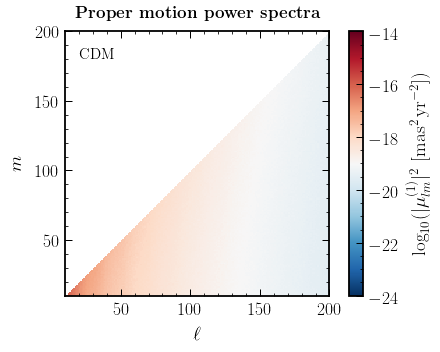

In [25]:
plt.figure(figsize=(8 / 1.2, 6 / 1.2))

plt.imshow(np.transpose(np.log10(fB_ary_compressed / 1e6)), 
           origin='lower',
           vmin=-24, vmax=-14,
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot],
           cmap='RdBu_r'
          )

cbar = plt.colorbar(label=r"$\log_{10}(|\mu_{lm}^{(1)}|^2$ [mas$^2$\,yr$^{-2}]$)")

plt.ylabel("$m$")
plt.xlabel("$\ell$")

plt.title('\\textbf{Proper motion power spectra}', fontsize=17, y=1.02)

plt.text(20, 180, "CDM", fontsize=15)

plt.tight_layout()
plt.savefig(plots_dir + "m_abs_1.pdf")

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


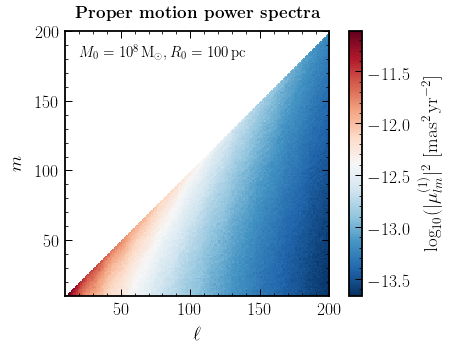

In [26]:
plt.figure(figsize=(8 / 1.2, 6 / 1.2))

plt.imshow(np.transpose(np.log10(fB_compact_ary_compressed / 1e6)), 
           origin='lower',
#            vmin=-24, vmax=-14,
           extent=[lmin_plot,lmax_plot, lmin_plot, lmax_plot],
           cmap='RdBu_r'
          )

cbar = plt.colorbar(label=r"$\log_{10}(|\mu_{lm}^{(1)}|^2$ [mas$^2$\,yr$^{-2}]$")

plt.ylabel("$m$")
plt.xlabel("$\ell$")

plt.title('\\textbf{Proper motion power spectra}', fontsize=17, y=1.02)

plt.text(20, 180, "$M_0 = 10^8\,\mathrm{M}_\odot, R_0 = 100\,\mathrm{pc}$", fontsize=15)

plt.tight_layout()
plt.savefig(plots_dir + "m_compact_abs_1.pdf")